### Библиотеки

In [81]:
import sys
sys.path.append("../modules")
sys.path.append("../dataset")
sys.path.append("../Moore-AnimateAnyone")

from torch.nn import CosineSimilarity
import torch
from transformers import CLIPVisionModelWithProjection, CLIPImageProcessor

from PIL import Image
from torchvision.transforms.functional import pil_to_tensor, to_pil_image
import torch
import glob
from tqdm import tqdm
import pandas as pd
import numpy as np

from metrics import get_cosine_similarity, get_pose_distance

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")
%config InlineBackend.figure_format='retina'

### Пример данных 

Сравним метрики:

* оригинальный кадр с оригинальным
* оригинальный кадр с шумом

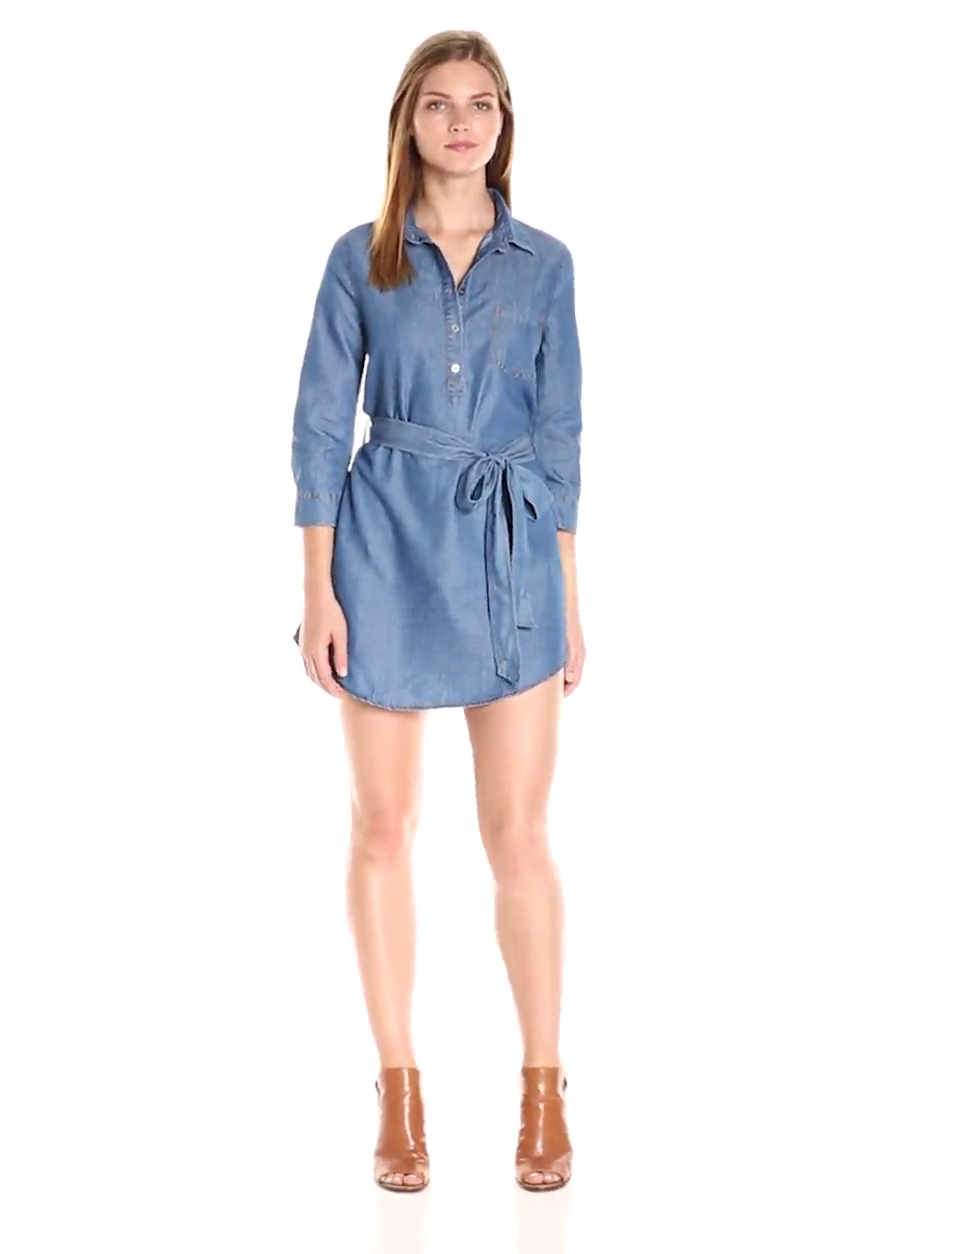

In [3]:
# оригинальный кадр
souce_image = Image.open("../dataset/test/stage_1/sample_0/source.png")
souce_image

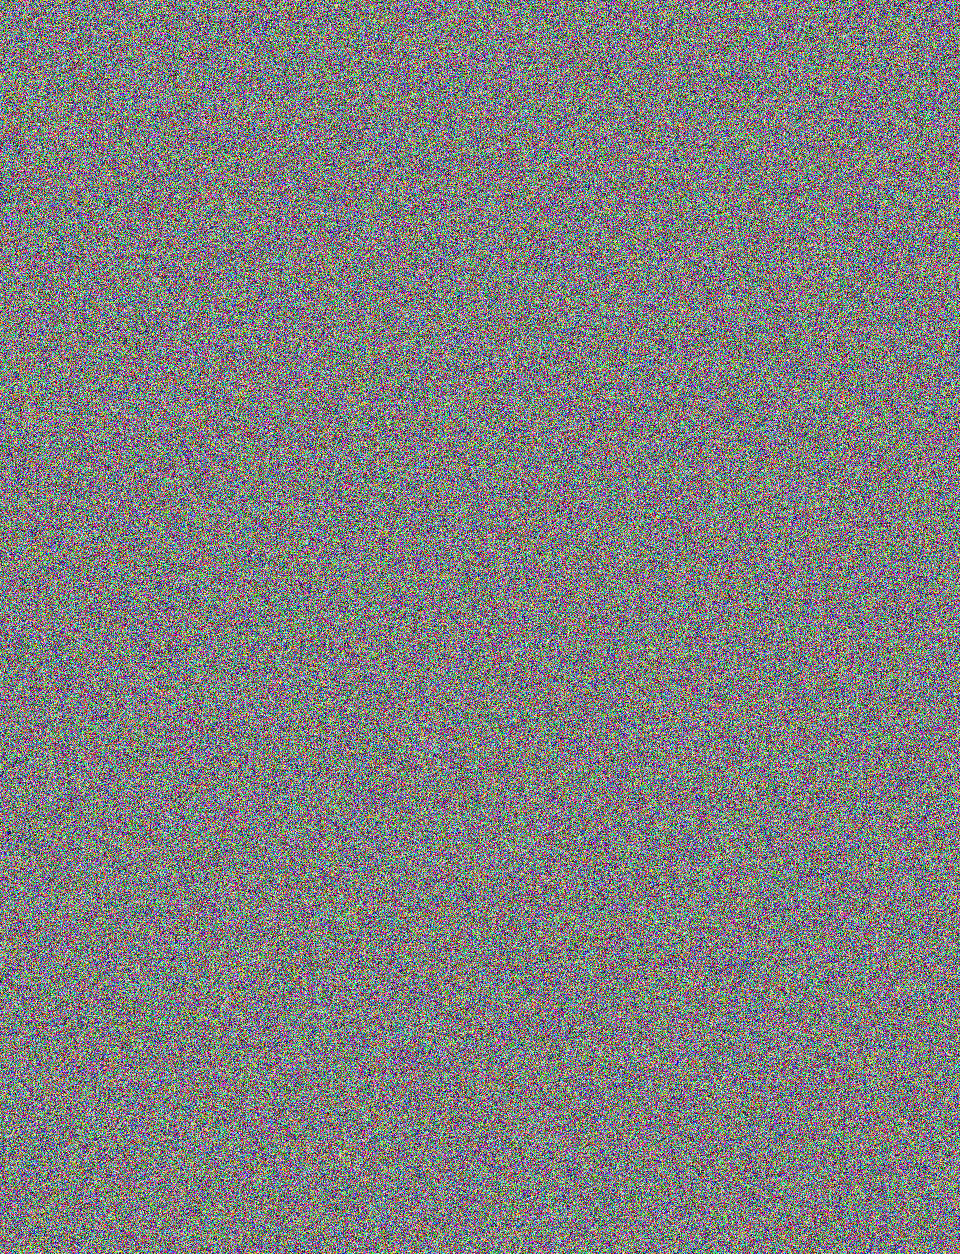

In [4]:
# шум
rand_tensor = torch.randn(pil_to_tensor(souce_image).shape)
noise = to_pil_image(rand_tensor)
noise

### CLIP

Чем боль метрика, тем сильнее похоже объекты

In [71]:
# подгрудаем веса предобученного CLIPImageProcessor
import os
os.chdir('../Moore-AnimateAnyone')
from src.dwpose import DWposeDetector

clip_image_processor = CLIPImageProcessor()
image_encoder = CLIPVisionModelWithProjection.from_pretrained(
    "./pretrained_weights/image_encoder"
).to(dtype=torch.float16, device="cuda")

os.chdir('../notebooks')

In [9]:
clip_sim = get_cosine_similarity(souce_image, noise, clip_image_processor, image_encoder)
print(f"Сравненеие с шумом: {round(clip_sim, 2)}")

Сравненеие с шумом: 0.46


In [10]:
clip_sim = get_cosine_similarity(souce_image, souce_image, clip_image_processor, image_encoder)
print(f"Сравненеие с оригиналом: {round(clip_sim, 2)}")

Сравненеие с оригиналом: 1.0


### PoseEstemator

Чем больше метрика, тем больше расстояние

In [72]:
# подгрудаем веса предобученного DWposeDetector
import os
os.chdir('../Moore-AnimateAnyone')
from src.dwpose import DWposeDetector

detector = DWposeDetector()
detector = detector.to(f"cuda")
os.chdir('../notebooks')

2025-05-04 11:40:59.232284381 [W:onnxruntime:, session_state.cc:1162 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2025-05-04 11:40:59.232315782 [W:onnxruntime:, session_state.cc:1164 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.


In [12]:
pose_sim = get_pose_distance(souce_image, noise, detector)
print(f"Сравненеие с шумом: {round(pose_sim, 2)}")

Сравненеие с шумом: 20.48


In [13]:
pose_sim = get_pose_distance(souce_image, souce_image, detector)
print(f"Сравненеие с оригиналом: {round(pose_sim, 2)}")

Сравненеие с оригиналом: 0.0


### Stage 1

In [115]:
def show_stage_1_result(sample_id, steps):
    source_path = glob.glob(f"../dataset/test/stage_1/sample_{sample_id}/source.png")
    pose_path = glob.glob(f"../dataset/test/stage_1/sample_{sample_id}/target_pose.png")
    target_path = glob.glob(f"../dataset/test/stage_1/sample_{sample_id}/target.png")
    
    target_image = Image.open(target_path[0])
    pose_image = Image.open(pose_path[0]).resize(target_image.size)
    source_image = Image.open(source_path[0])

    step_pic = [source_image, pose_image]
    for step in steps:
        step_path = glob.glob(f"../dataset/test/stage_1/sample_{sample_id}/generationstep_*{step}.png")
        step_image = Image.open(step_path[0])
        step_pic.append(np.asarray(step_image.resize(target_image.size)))

    step_pic.append(target_image)

    combined = np.hstack(step_pic)
    plt.figure(figsize=(15, 5))
    plt.imshow(combined)
    plt.axis('off')


    captions = ["Source", "Pose"] + [f"Step {step}" for step in steps] + ["Target"] 
    num_images = len(step_pic)
    image_width = combined.shape[1] / num_images
    
    for i, caption in enumerate(captions):
        x_position = (i + 0.5) * image_width
        plt.text(x_position, target_image.size[1] + 30, caption, 
                 ha='center', va='top', fontsize=12, color='black')
    
    plt.tight_layout()
    plt.show()

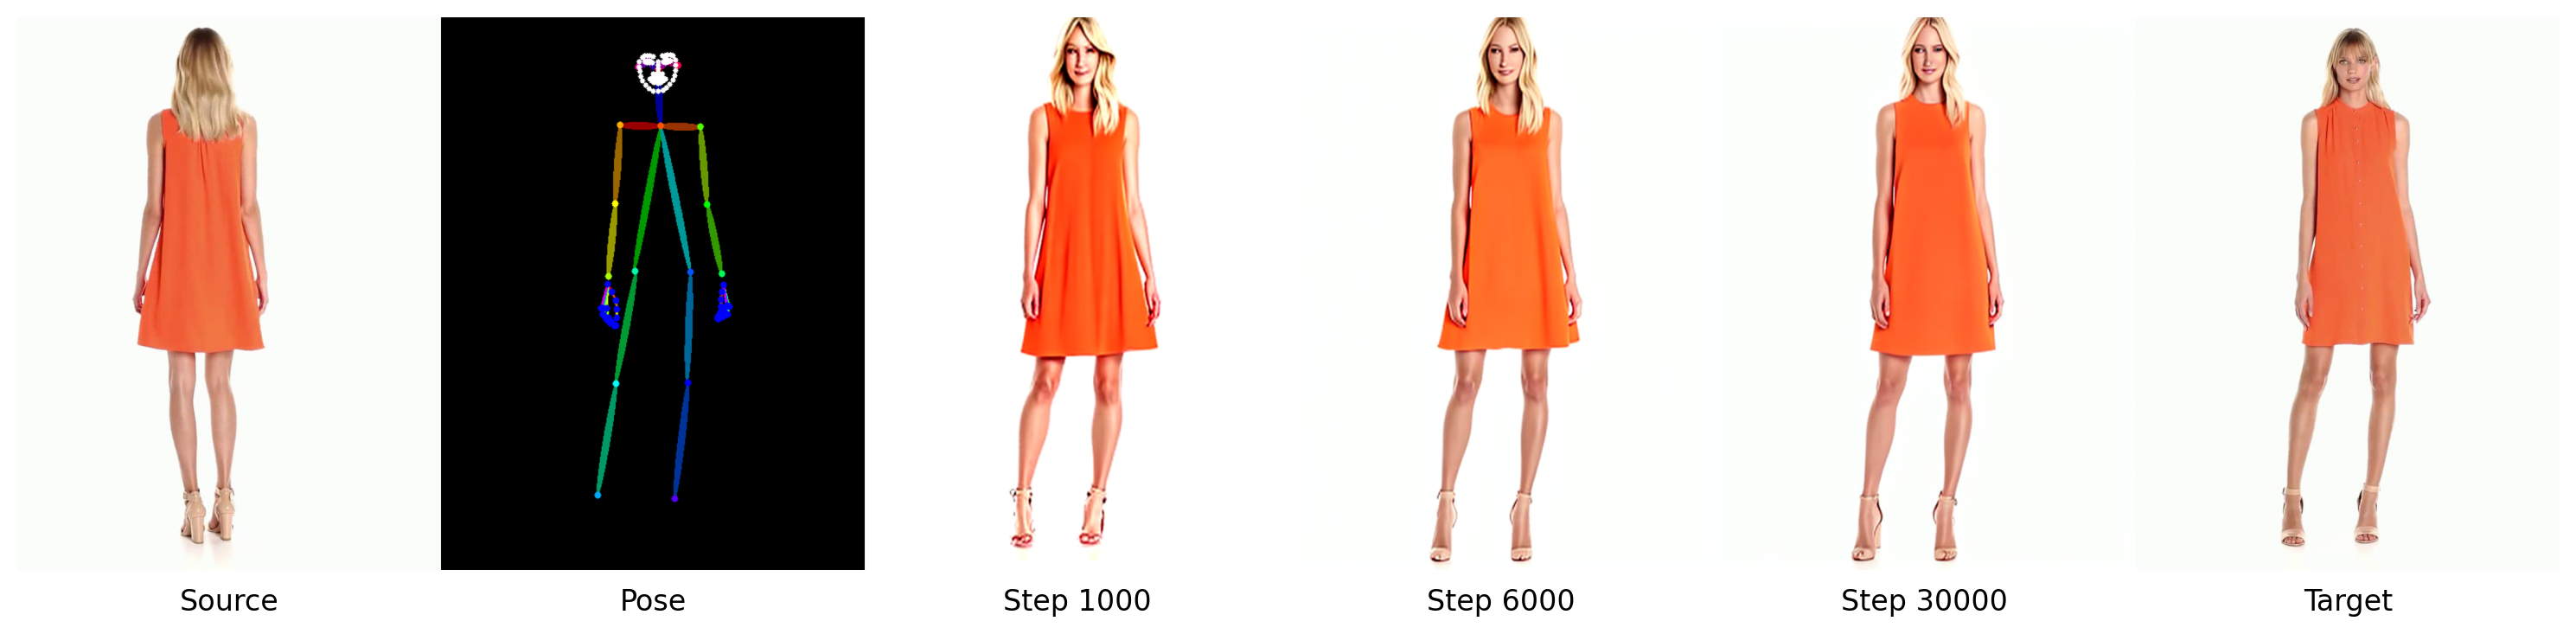

In [131]:
show_stage_1_result(28, [1000, 6000, 30000])

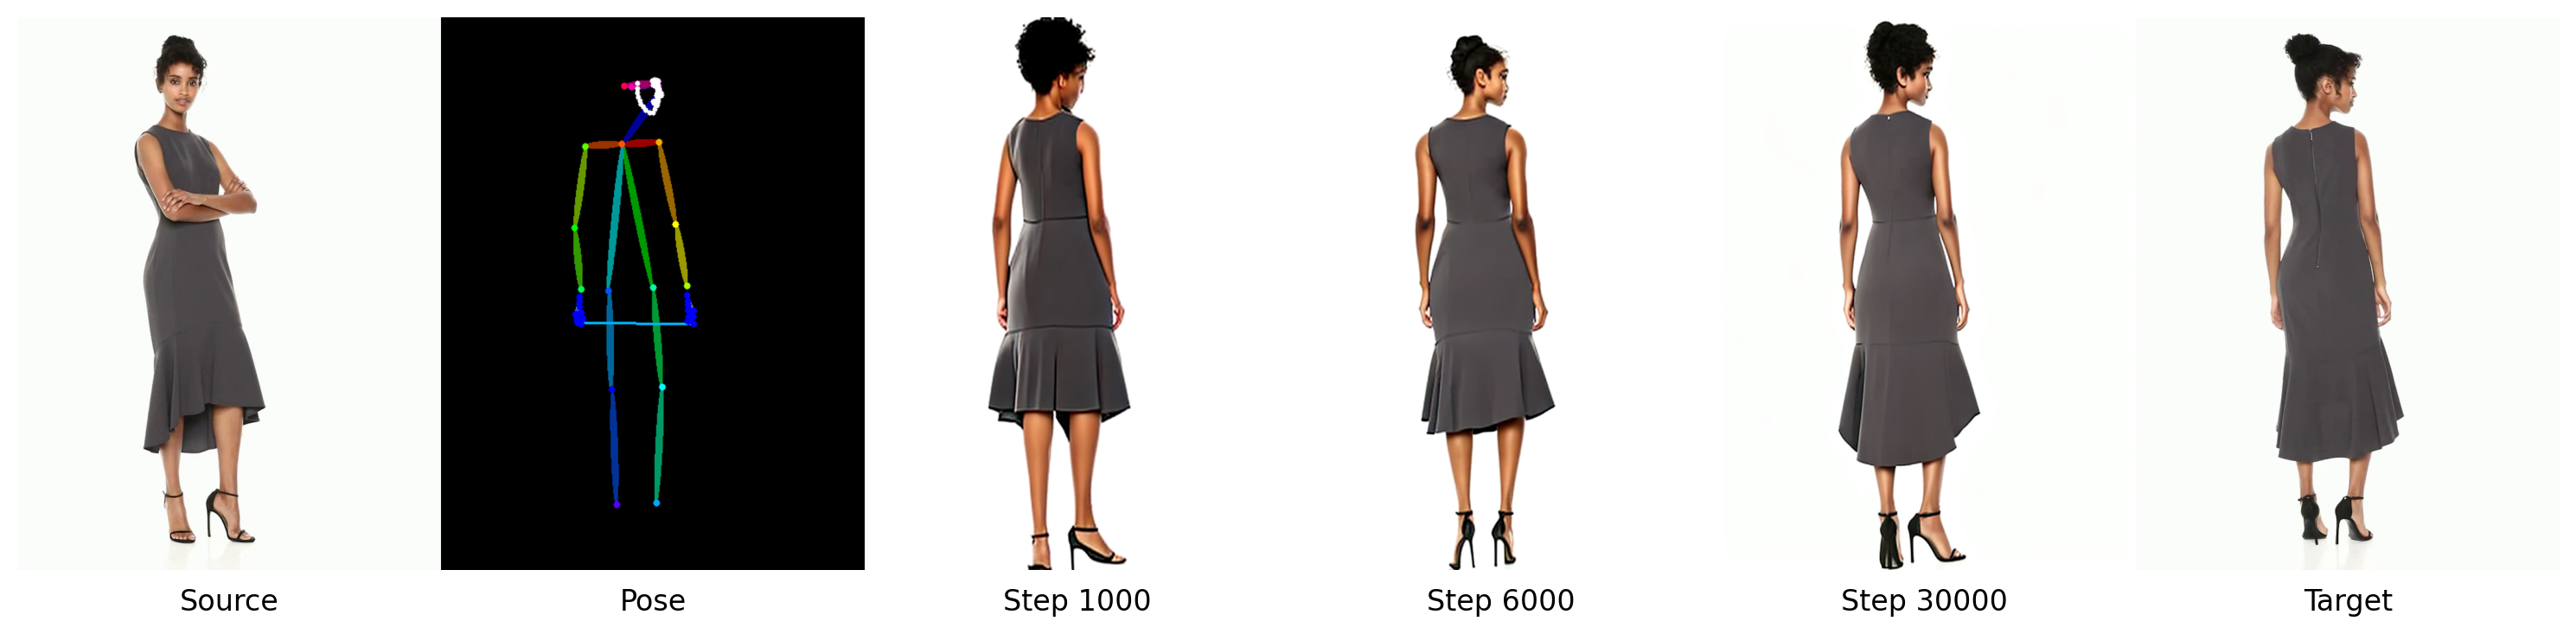

In [136]:
show_stage_1_result(6, [1000, 6000, 30000])

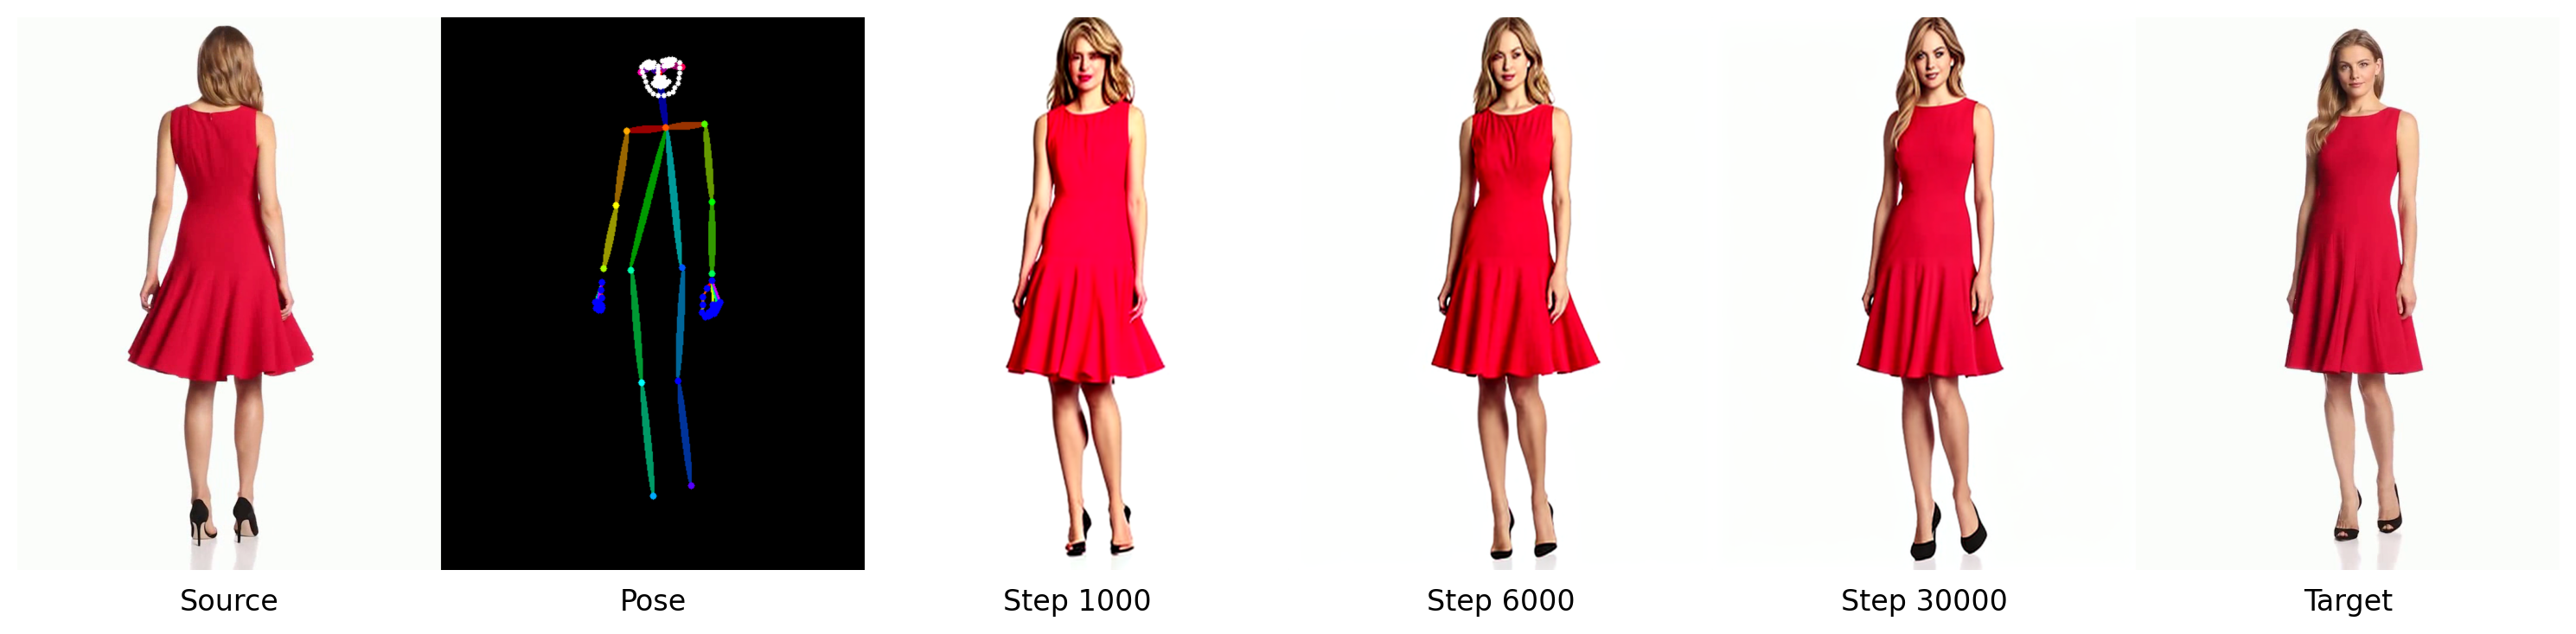

In [133]:
show_stage_1_result(10, [1000, 6000, 30000])

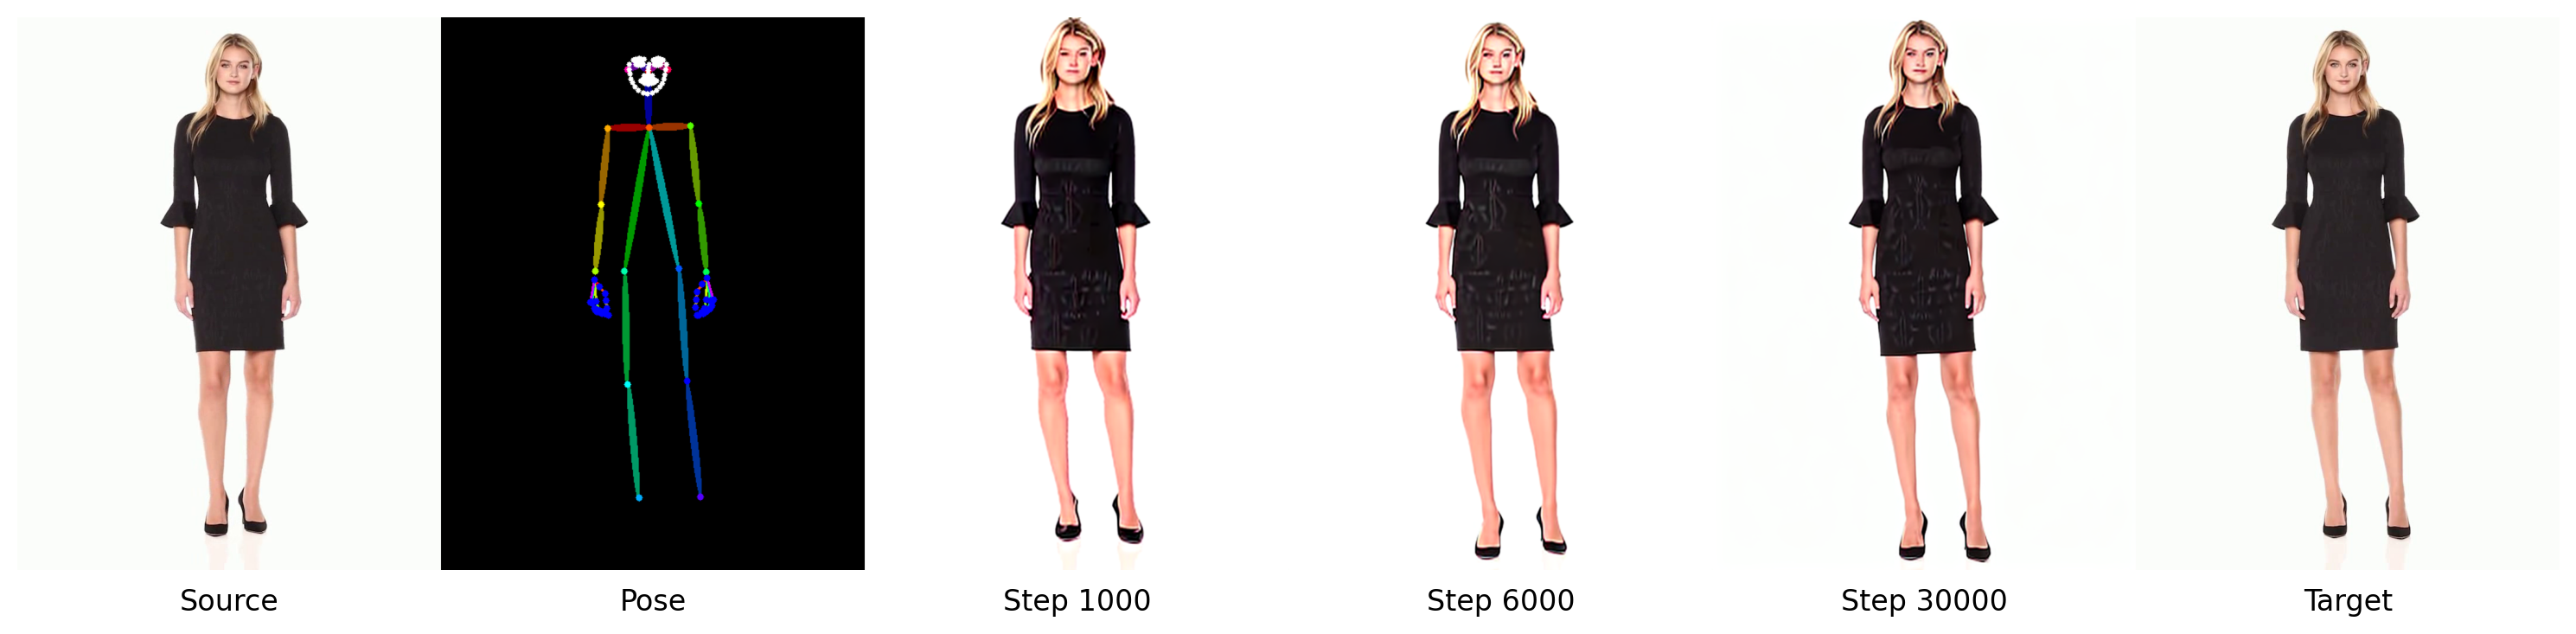

In [135]:
show_stage_1_result(16, [1000, 6000, 30000])

#### Метрики

In [125]:
data = []
for i in tqdm(range(50)):
    target_path = glob.glob(f"../dataset/test/stage_1/sample_{i}/target.png")
    generated_path = glob.glob(f"../dataset/test/stage_1/sample_{i}/generationstep*")
    sample_data = {}
    source_image = Image.open(target_path[0])
    
    for gen in generated_path:
        epoch = int(gen.split('/')[-1].strip('.png').split('_')[-1])
        generated_image = Image.open(gen).resize(source_image.size)
        
        pose_sim = get_pose_distance(source_image, generated_image, detector)
        clip_sim = get_cosine_similarity(source_image, generated_image, clip_image_processor, image_encoder)

        sample_data[epoch] = {
            "pose_sim" : pose_sim,
            "clip_sim" : clip_sim
        }

    data.append(sample_data)

100%|██████████| 50/50 [03:55<00:00,  4.71s/it]


In [126]:
records = []
for i, run in enumerate(data):
    for epoch, metrics in run.items():
        record = {
            "run": i,
            "epoch": epoch,
            **metrics
        }
        records.append(record)

df = pd.DataFrame.from_records(records)
df.set_index(["run", "epoch"], inplace=True)

In [127]:
#df.to_csv('stage_1_results.csv')
df = pd.read_csv('stage_1_results.csv')#.set_index(['run', 'epoch'])
df = df[df['pose_sim'] <= df['pose_sim'].quantile(0.8)]

In [128]:
step_data = df.groupby('epoch').mean()
step_data

run  pose_sim  clip_sim
epoch                               
1000   24.583333  0.165540  0.876248
2000   26.088235  0.169220  0.883760
3000   26.514286  0.165609  0.906334
4000   25.675676  0.167993  0.900615
5000   25.342105  0.165787  0.887117
6000   26.236842  0.155388  0.886423
7000   26.058824  0.171265  0.876738
8000   25.864865  0.165464  0.907372
9000   25.857143  0.170267  0.896984
10000  26.282051  0.169256  0.887245
11000  25.926829  0.167352  0.901867
12000  25.390244  0.168441  0.887993
13000  25.225000  0.172064  0.899500
14000  24.853659  0.172653  0.890911
15000  25.275000  0.172293  0.894006
16000  25.829268  0.168830  0.898044
17000  25.857143  0.172530  0.892229
18000  25.414634  0.166987  0.899414
19000  25.857143  0.171873  0.902855
20000  25.390244  0.167642  0.895008
21000  25.818182  0.169842  0.899958
22000  25.720930  0.172605  0.904127
23000  25.414634  0.172141  0.898342
24000  25.414634  0.170127  0.898283
25000  25.720930  0.171704  0.897699
26000  25.720930  0.172445  0.898233
27000  25.285714  0.172466  0.895868
28000  25.720930  0.172294  0.894792
29000  25.414634  0.171811  0.894722
30000  25.846154  0.169247  0.884190

<Axes: xlabel='epoch', ylabel='pose_sim'>

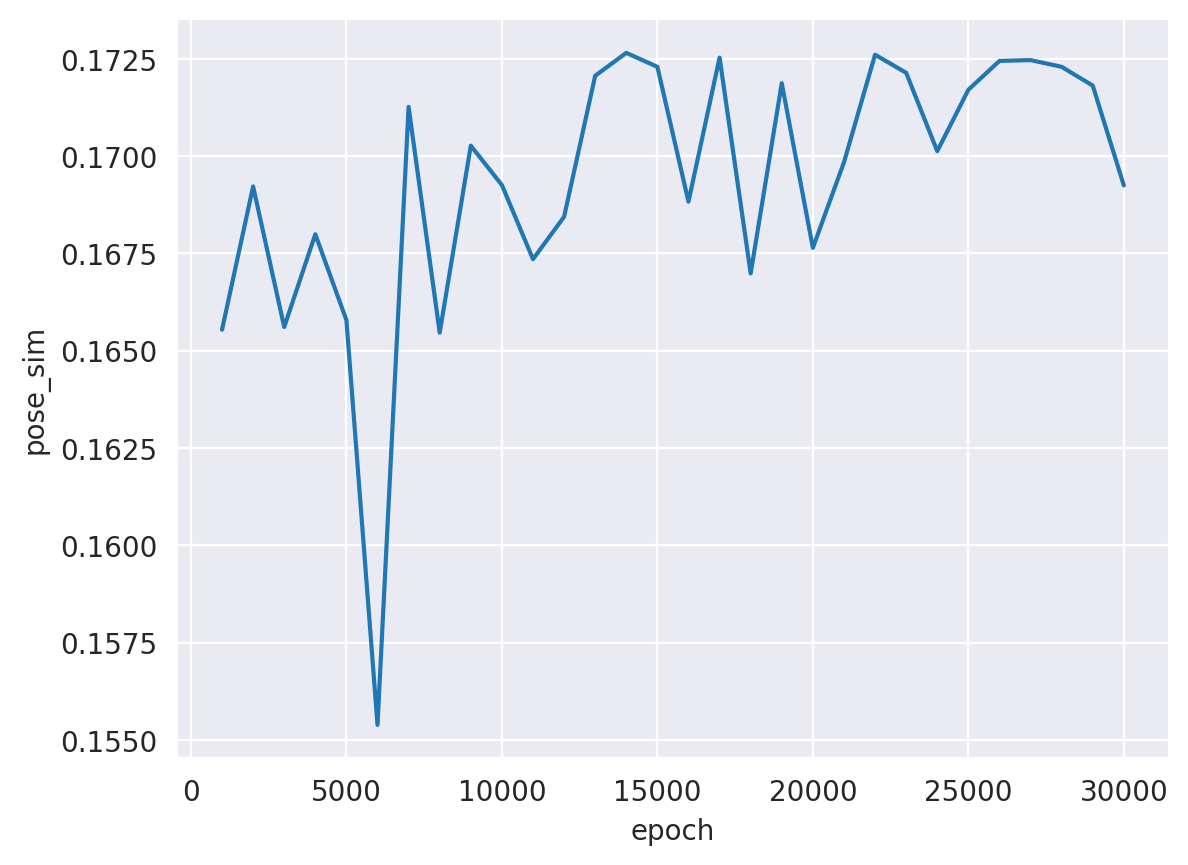

In [129]:
sns.lineplot(data = step_data, x=step_data.index, y='pose_sim')

<Axes: xlabel='epoch', ylabel='clip_sim'>

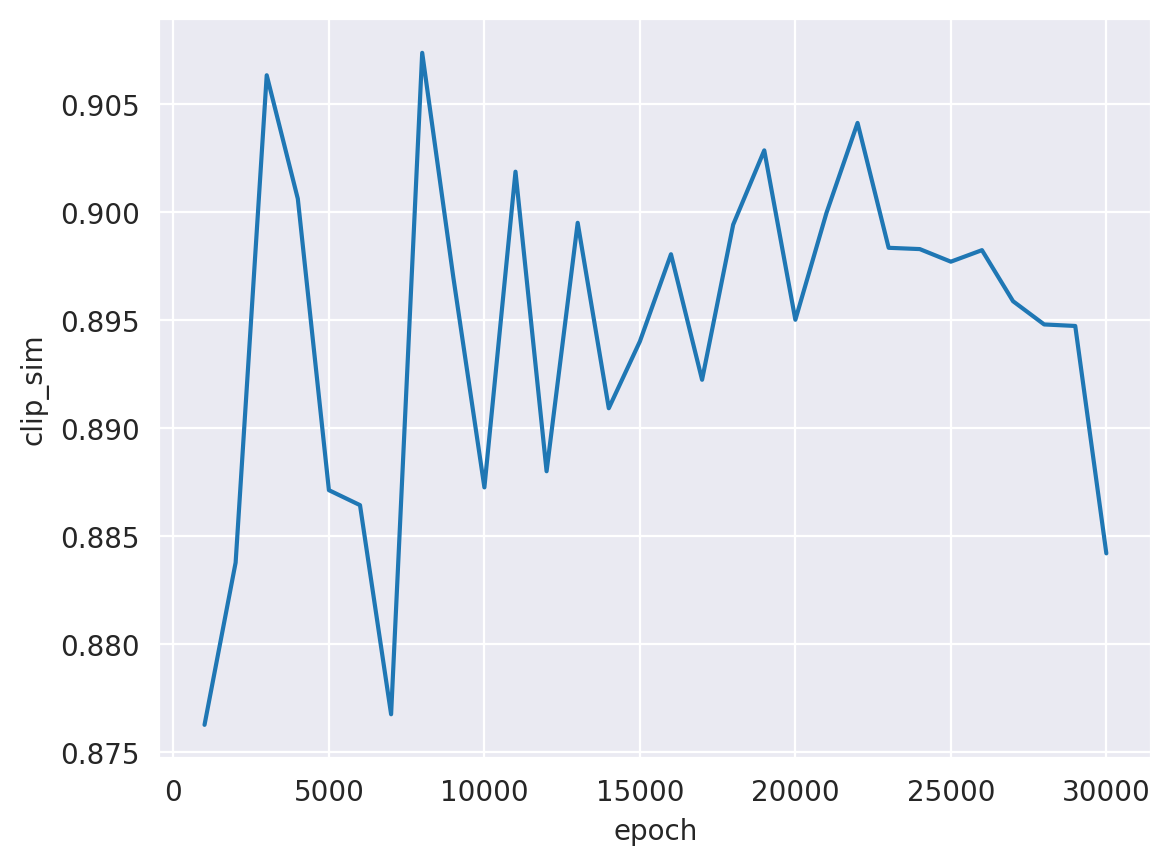

In [130]:
sns.lineplot(data = step_data, x=step_data.index, y='clip_sim')

___